---
title: "Probabilistic Programming in Turing.jl"
author: "Mattias Villani"
editor: visual
---

#### IID normal model

$$
X_1,\ldots,X_n \vert \mu, \sigma^2 \overset{iid}{\sim} N(\mu, \sigma^2)
$$

Prior

$$
\sigma^2 \sim \chi^2(\nu_0, \sigma_0^2)
$$

$$
\mu \vert \sigma^2 \sim N\Big(\mu_0, \frac{\sigma^2}{\kappa_0}\Big)
$$

┌ Info: Found initial step size
└   ϵ = 0.2


Sampling:   8%|███▎                                     |  ETA: 0:00:01

Sampling:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


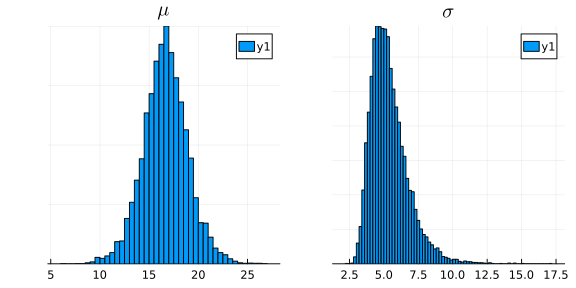

In [1]:
using Turing, Plots, LaTeXStrings

ScaledInverseChiSq(ν,τ²) = InverseGamma(ν/2,ν*τ²/2) # Scaled Inv-χ² distribution

# Setting up the Turing model:
@model function iidnormal(x, μ₀, κ₀, ν₀, σ²₀)
    σ² ~ ScaledInverseChiSq(ν₀, σ²₀)
    θ ~ Normal(μ₀, √(σ²/κ₀))  # prior
    n = length(x)  # number of observations
    for i in 1:n
        x[i] ~ Normal(θ, √σ²) # model
    end
end

# Set up the observed data
x = [15.77,20.5,8.26,14.37,21.09]

# Set up the prior
μ₀ = 20; κ₀ = 1; ν₀ = 5; σ²₀ = 5^2

# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
α = 0.8
postdraws = sample(iidnormal(x, μ₀, κ₀, ν₀, σ²₀), NUTS(α), 10000, discard_initial = 1000)

p1 = histogram(postdraws.value[:,2], yaxis = false, title = L"\mu")
p2 = histogram(sqrt.(postdraws.value[:,1]), yaxis = false, title = L"\sigma")
plot(p1, p2, layout = (1,2), size = (600,300))

#### **Poisson regression**

$$
y_i \vert \boldsymbol{x}_i \sim\mathrm{Poisson}(\lambda_i) \\
$$

with log link

$$
\lambda_{i} =\exp(\boldsymbol{x}_{i}^{\top}\boldsymbol{\beta})
$$

and multivariate normal prior

$$
\boldsymbol{\beta} \sim N(\boldsymbol{0}, \tau^2 \boldsymbol{I})
$$

![](figs/ebaydatatable.png){width="800"}

In [2]:
using Turing, CSV, Downloads, DataFrames, LinearAlgebra, LaTeXStrings, Plots

# Reading and transforming the eBay data
url = "https://github.com/mattiasvillani/BayesianLearningBook/raw/main/data/ebaybids/ebaybids.csv" 
df = CSV.read(Downloads.download(url), DataFrame)
n = size(df,1)
y = df[:,:NBidders]
X = [ones(n,1) log.(df.BookVal) .- mean(log.(df.BookVal)) df.ReservePriceFrac .- mean(df.ReservePriceFrac) df.MinorBlem df.MajorBlem  df.NegFeedback df.PowerSeller df.IDSeller df.Sealed]

varnames = ["intercept", "logbook", "startprice", "minblemish", "majblemish",    
      "negfeedback", "powerseller", "verified", "sealed"]

9-element Vector{String}:
 "intercept"
 "logbook"
 "startprice"
 "minblemish"
 "majblemish"
 "negfeedback"
 "powerseller"
 "verified"
 "sealed"

The Poisson regression with its prior is set up as Turing.jl using the @model macro:

In [3]:
# Setting up the poisson regression model
@model function poissonReg(y, X, τ)
    p = size(X,2)
    β ~ filldist(Normal(0, τ), p)  # all βⱼ are iid Normal(0, τ)
    λ = exp.(X*β)
    n = length(y)  
    for i in 1:n
        y[i] ~ Poisson(λ[i]) 
    end
end

poissonReg (generic function with 2 methods)

┌ Info: Found initial step size
└   ϵ = 6.103515625e-6


Sampling:   2%|▋                                        |  ETA: 0:00:17

Sampling:   2%|█                                        |  ETA: 0:00:18

Sampling:   4%|█▍                                       |  ETA: 0:00:17

Sampling:   4%|█▉                                       |  ETA: 0:00:17

Sampling:   6%|██▎                                      |  ETA: 0:00:16

Sampling:   6%|██▋                                      |  ETA: 0:00:15

Sampling:   8%|███▏                                     |  ETA: 0:00:15

Sampling:   8%|███▌                                     |  ETA: 0:00:15

Sampling:  10%|███▉                                     |  ETA: 0:00:15

Sampling:  10%|████▎                                    |  ETA: 0:00:15

Sampling:  12%|████▊                                    |  ETA: 0:00:14

Sampling:  12%|█████▏                                   |  ETA: 0:00:14

Sampling:  14%|█████▌                                   |  ETA: 0:00:14

Sampling:  14%|██████                                   |  ETA: 0:00:14

Sampling:  16%|██████▍                                  |  ETA: 0:00:13

Sampling:  16%|██████▊                                  |  ETA: 0:00:13

Sampling:  18%|███████▏                                 |  ETA: 0:00:13

Sampling:  18%|███████▋                                 |  ETA: 0:00:13

Sampling:  20%|████████                                 |  ETA: 0:00:13

Sampling:  20%|████████▍                                |  ETA: 0:00:12

Sampling:  22%|████████▉                                |  ETA: 0:00:12

Sampling:  22%|█████████▎                               |  ETA: 0:00:12

Sampling:  24%|█████████▋                               |  ETA: 0:00:12

Sampling:  24%|██████████                               |  ETA: 0:00:12

Sampling:  26%|██████████▌                              |  ETA: 0:00:12

Sampling:  26%|██████████▉                              |  ETA: 0:00:11

Sampling:  28%|███████████▎                             |  ETA: 0:00:11

Sampling:  28%|███████████▋                             |  ETA: 0:00:11

Sampling:  30%|████████████▏                            |  ETA: 0:00:11

Sampling:  30%|████████████▌                            |  ETA: 0:00:11

Sampling:  32%|████████████▉                            |  ETA: 0:00:11

Sampling:  32%|█████████████▍                           |  ETA: 0:00:11

Sampling:  34%|█████████████▊                           |  ETA: 0:00:10

Sampling:  34%|██████████████▏                          |  ETA: 0:00:10

Sampling:  36%|██████████████▌                          |  ETA: 0:00:10

Sampling:  36%|███████████████                          |  ETA: 0:00:10

Sampling:  38%|███████████████▍                         |  ETA: 0:00:10

Sampling:  38%|███████████████▊                         |  ETA: 0:00:10

Sampling:  40%|████████████████▎                        |  ETA: 0:00:09

Sampling:  40%|████████████████▋                        |  ETA: 0:00:09

Sampling:  42%|█████████████████                        |  ETA: 0:00:09

Sampling:  42%|█████████████████▍                       |  ETA: 0:00:09

Sampling:  44%|█████████████████▉                       |  ETA: 0:00:09

Sampling:  44%|██████████████████▎                      |  ETA: 0:00:09

Sampling:  46%|██████████████████▋                      |  ETA: 0:00:08

Sampling:  46%|███████████████████▏                     |  ETA: 0:00:08

Sampling:  48%|███████████████████▌                     |  ETA: 0:00:08

Sampling:  48%|███████████████████▉                     |  ETA: 0:00:08

Sampling:  50%|████████████████████▎                    |  ETA: 0:00:08

Sampling:  50%|████████████████████▊                    |  ETA: 0:00:08

Sampling:  52%|█████████████████████▏                   |  ETA: 0:00:08

Sampling:  52%|█████████████████████▌                   |  ETA: 0:00:07

Sampling:  54%|█████████████████████▉                   |  ETA: 0:00:07

Sampling:  54%|██████████████████████▍                  |  ETA: 0:00:07

Sampling:  56%|██████████████████████▊                  |  ETA: 0:00:07

Sampling:  56%|███████████████████████▏                 |  ETA: 0:00:07

Sampling:  58%|███████████████████████▋                 |  ETA: 0:00:07

Sampling:  58%|████████████████████████                 |  ETA: 0:00:06

Sampling:  60%|████████████████████████▍                |  ETA: 0:00:06

Sampling:  60%|████████████████████████▊                |  ETA: 0:00:06

Sampling:  62%|█████████████████████████▎               |  ETA: 0:00:06

Sampling:  62%|█████████████████████████▋               |  ETA: 0:00:06

Sampling:  64%|██████████████████████████               |  ETA: 0:00:06

Sampling:  64%|██████████████████████████▌              |  ETA: 0:00:06

Sampling:  66%|██████████████████████████▉              |  ETA: 0:00:05

Sampling:  66%|███████████████████████████▎             |  ETA: 0:00:05

Sampling:  68%|███████████████████████████▋             |  ETA: 0:00:05

Sampling:  68%|████████████████████████████▏            |  ETA: 0:00:05

Sampling:  70%|████████████████████████████▌            |  ETA: 0:00:05

Sampling:  70%|████████████████████████████▉            |  ETA: 0:00:05

Sampling:  72%|█████████████████████████████▍           |  ETA: 0:00:04

Sampling:  72%|█████████████████████████████▊           |  ETA: 0:00:04

Sampling:  74%|██████████████████████████████▏          |  ETA: 0:00:04

Sampling:  74%|██████████████████████████████▌          |  ETA: 0:00:04

Sampling:  76%|███████████████████████████████          |  ETA: 0:00:04

Sampling:  76%|███████████████████████████████▍         |  ETA: 0:00:04

Sampling:  78%|███████████████████████████████▊         |  ETA: 0:00:03

Sampling:  78%|████████████████████████████████▏        |  ETA: 0:00:03

Sampling:  80%|████████████████████████████████▋        |  ETA: 0:00:03

Sampling:  80%|█████████████████████████████████        |  ETA: 0:00:03

Sampling:  82%|█████████████████████████████████▍       |  ETA: 0:00:03

Sampling:  82%|█████████████████████████████████▉       |  ETA: 0:00:03

Sampling:  84%|██████████████████████████████████▎      |  ETA: 0:00:03

Sampling:  84%|██████████████████████████████████▋      |  ETA: 0:00:02

Sampling:  86%|███████████████████████████████████      |  ETA: 0:00:02

Sampling:  86%|███████████████████████████████████▌     |  ETA: 0:00:02

Sampling:  88%|███████████████████████████████████▉     |  ETA: 0:00:02

Sampling:  88%|████████████████████████████████████▎    |  ETA: 0:00:02

Sampling:  90%|████████████████████████████████████▊    |  ETA: 0:00:02

Sampling:  90%|█████████████████████████████████████▏   |  ETA: 0:00:01

Sampling:  92%|█████████████████████████████████████▌   |  ETA: 0:00:01

Sampling:  92%|█████████████████████████████████████▉   |  ETA: 0:00:01

Sampling:  94%|██████████████████████████████████████▍  |  ETA: 0:00:01

Sampling:  94%|██████████████████████████████████████▊  |  ETA: 0:00:01

Sampling:  96%|███████████████████████████████████████▏ |  ETA: 0:00:01

Sampling:  96%|███████████████████████████████████████▋ |  ETA: 0:00:01

Sampling:  98%|████████████████████████████████████████ |  ETA: 0:00:00

Sampling:  98%|████████████████████████████████████████▍|  ETA: 0:00:00

Sampling:  99%|████████████████████████████████████████▊|  ETA: 0:00:00

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:15


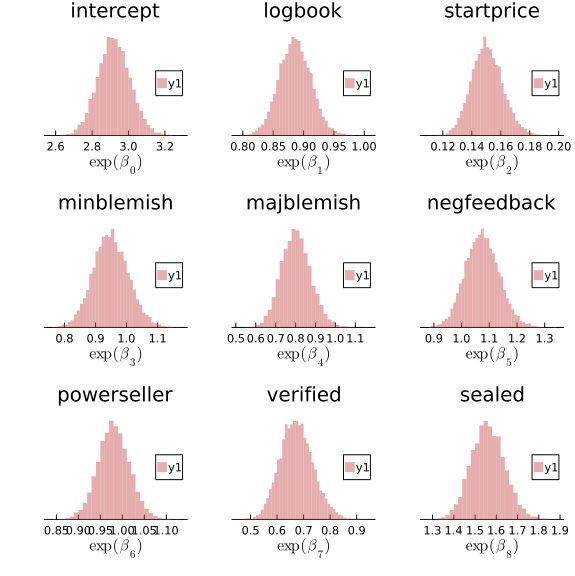

In [4]:
# HMC sampling from posterior
p = size(X, 2)
μ = zeros(p)    # Prior mean
τ = 10          # Prior standard deviation Σ = τ²I
α = 0.70        # target acceptance probability in NUTS sampler
model = poissonReg(y, X, τ)
chain = sample(model, NUTS(α), 10000, discard_initial = 1000, verbose = false)
rateratio = exp.(chain.value) # exp(β) is the incidence rate ratio

gr(grid = false)
h = []
for i = 1:p
    ptmp = histogram(rateratio[:,i], nbins = 50, fillcolor = :indianred, linecolor = nothing, 
        normalize = true, title = varnames[i], xlab = L"\exp(\beta_{%$(i-1)})", 
        yaxis = false, fillopacity = 0.5)    
    push!(h, ptmp)
end
plot(h..., size = (600,600), legend = :right)